In [35]:
%matplotlib inline
import sys, os
#os.environ['COBAYA_NOMPI'] = 'True'
#sys.path.append('../../CobayaLSS/')
#sys.path.append('../../CobayaLSS/lss_likelihood/')
#sys.path.append('../')
#from cobaya.model import get_model
#from cobaya.yaml import yaml_load
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from numba import jit
import yaml
import h5py
import json

plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18

from train_nn_emu import train_emu
from emulator import Emulator
from low_discrepancy import Parameters

In [2]:
ngauss=4
mu, ws = np.polynomial.legendre.leggauss(2*ngauss)
L0 = np.polynomial.legendre.Legendre((1))(mu)
L2 = np.polynomial.legendre.Legendre((0,0,1))(mu)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(mu)
mu = mu[0:ngauss]
mu_calc = np.zeros(len(mu)*2)
mu_calc[:len(mu)] = mu
mu_calc[len(mu):] = np.flip(mu)

@jit(nopython=True)
def make_pkell_fixedshape(k, pk_lin, b, f, sigma8, sigmav, mu_calc=mu_calc, ws=ws, L0=L0, L2=L2, L4=L4):
    
    pkmu = ((b + f * mu_calc.reshape(-1,1)**2)**2 * pk_lin.reshape(1,-1) * sigma8**2  
            * 1/(1 + k.reshape(1,-1) **2 * mu_calc.reshape(-1,1) **2 * sigmav**2))

    p0k = 0.5 * np.sum((ws*L0).reshape(-1,1)*pkmu,axis=0) 
    p2k = 2.5 * np.sum((ws*L2).reshape(-1,1)*pkmu,axis=0) 
    p4k = 4.5 * np.sum((ws*L4).reshape(-1,1)*pkmu,axis=0) 
    
    return p0k, p2k, p4k

In [34]:
nk = 100
k = np.logspace(-3,0,nk)
pk_lin = np.loadtxt('pk_lin.txt')

In [13]:
nsample = 1000000
# set parameter bounds for b, f, sigma8, sigmav
pmin = np.array([0.0, 0.0, 0.0, 0.0])
pmax = np.array([5.0, 1.0, 1.5, 100])

#Generate Korbov sequence to sample points from
qrs = Parameters(pmin, pmax)

In [14]:
#generate some training data from our simple fixed shape model
F = np.zeros((nsample, nk, 3))
P = np.zeros((nsample, 4))
for i in range(nsample):
    pars = qrs.sample(i)
    p0,p2,p4 = make_pkell_fixedshape(k, pk_lin, pars[0], pars[1], pars[2], pars[3])
    F[i,:,0] = p0
    F[i,:,1] = p2    
    F[i,:,2] = p4
    P[i,:] = pars
                      

(0.0, 0.5)

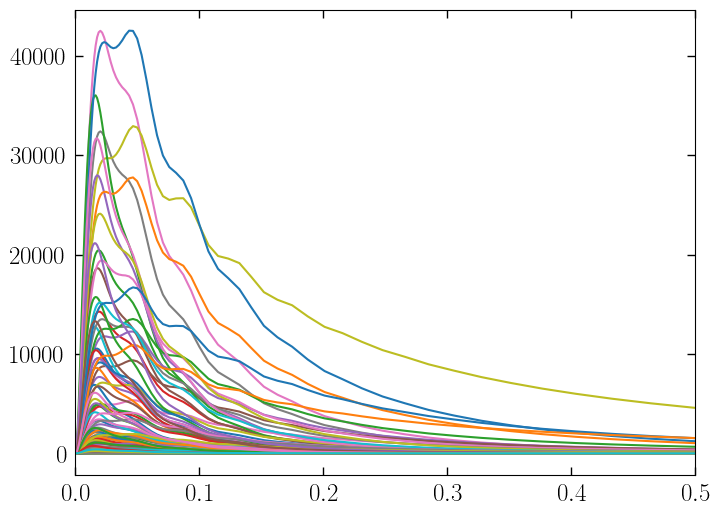

In [15]:
#plot our training data
plt.plot(k, k[:,np.newaxis] * F[::10000, :, 0].T);
plt.xlim([0, 0.5])

<ipython-input-17-1f7371b52c84>:8: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(np.arange(100), 1-np.cumsum(np.sqrt(w))/np.sum(np.sqrt(np.abs(w))))


Text(0, 0.5, '$1-\\sum_{i<N_{\\rm PC}} \\Lambda_{i}^{1/2} / \\rm{ Tr }(\\mathbf{\\Lambda}^{1/2})$')

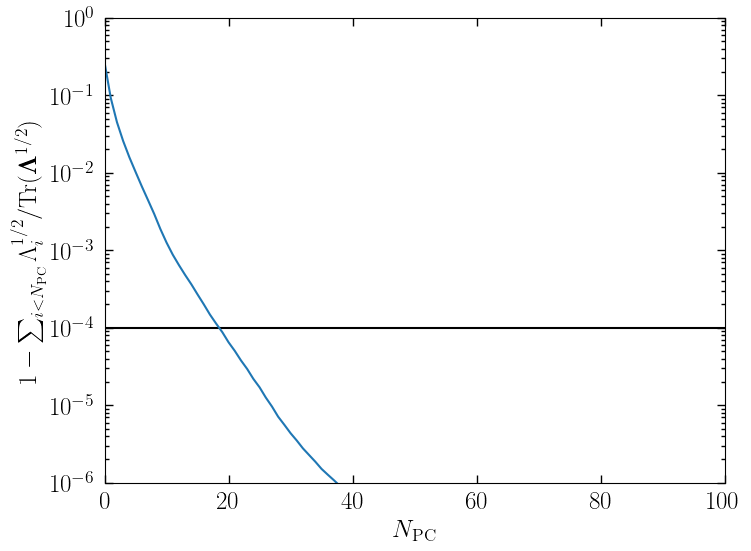

In [17]:
#how many PCs to use?
Ftrain = np.arcsinh(F[:,:,0])
cov_matrix = np.cov(Ftrain.T)
w, v = np.linalg.eigh(cov_matrix)
w = np.flip(w)
v = np.flip(v, axis=1)

plt.semilogy(np.arange(100), 1-np.cumsum(np.sqrt(w))/np.sum(np.sqrt(np.abs(w))))
plt.hlines(1e-4, 0, 200, color='k')
plt.ylim([10**-6,1])
plt.xlim([0,100])
plt.xlabel(r'$N_{\rm PC}$')
plt.ylabel(r'$1-\sum_{i<N_{\rm PC}} \Lambda_{i}^{1/2} / \rm{ Tr }(\mathbf{\Lambda}^{1/2})$')

In [18]:
vexpl = 1-np.cumsum(np.sqrt(w))/np.sum(np.sqrt(np.abs(w)))
vexpl = np.flip(vexpl)
n_pcs = nk - vexpl.searchsorted(1e-4)

<ipython-input-18-3d3bcd706683>:1: RuntimeWarning: invalid value encountered in sqrt
  vexpl = 1-np.cumsum(np.sqrt(w))/np.sum(np.sqrt(np.abs(w)))


In [20]:
#write emulators to a path with this base
output_path = 'basic_pkell_emu'

#some training hyperparameters
learning_rate = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
nbatchs = [320, 640, 1280, 2560, 5120]
n_hidden = [128, 128]
n_epochs = 100
#whether or not to scale by arcsinh, whiten training data. Usually want to do this.
use_asinh = True
scale_by_std = True
val_frac = 0.8

#start with p0
Ftrain = np.copy(F[:,:,0])

if use_asinh:
    if scale_by_std:
        print('use asinh, scaled')
        sys.stdout.flush()
        Fstd = np.std(Ftrain, axis=0)
        Ftrain = np.arcsinh(Ftrain/Fstd)
else:
    Ftrain = np.arcsinh(Ftrain)
    Fstd = np.ones(Ftrain.shape[-1])

Pmean = np.mean(P,axis=0)
Psigmas = np.std(P,axis=0)
Ptrain = (P - Pmean)/Psigmas

use asinh, scaled


In [ ]:
#train emulator
emu = train_emu(Ptrain, Ftrain, validation_frac=val_frac, n_hidden=n_hidden, n_pcs=n_pcs, n_epochs=n_epochs,
                fstd=Fstd, pmean=Pmean, pstd=Psigmas, outfile=output_path+'_p0', lrs=learning_rate, nbatchs=nbatchs)            

In [22]:
emu = Emulator(output_path+'_p0')

In [23]:
Pval = P[int(nsample*val_frac):]
Fval = F[int(nsample*val_frac):,:,0]
_, Fpred = emu(Pval)

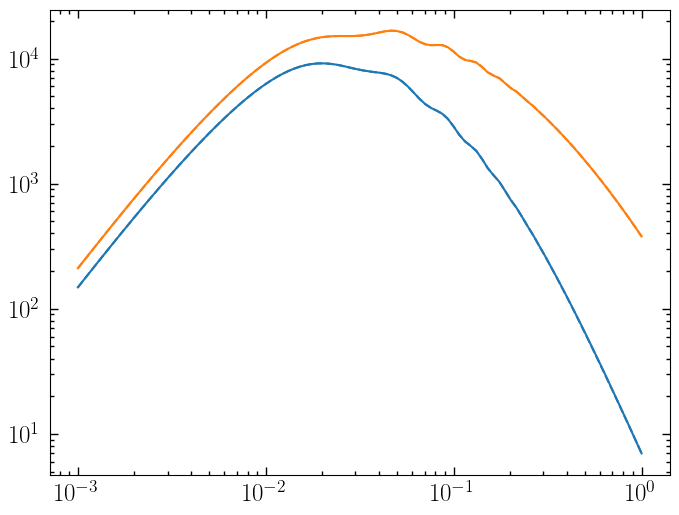

In [25]:
plt.loglog(k, k[:,np.newaxis] * Fval[::100000,:].T);
plt.gca().set_prop_cycle(None)
plt.loglog(k, k[:,np.newaxis] * Fpred[::100000,:].T, ls='--');


In [26]:
p0err = (Fpred - Fval)/Fval

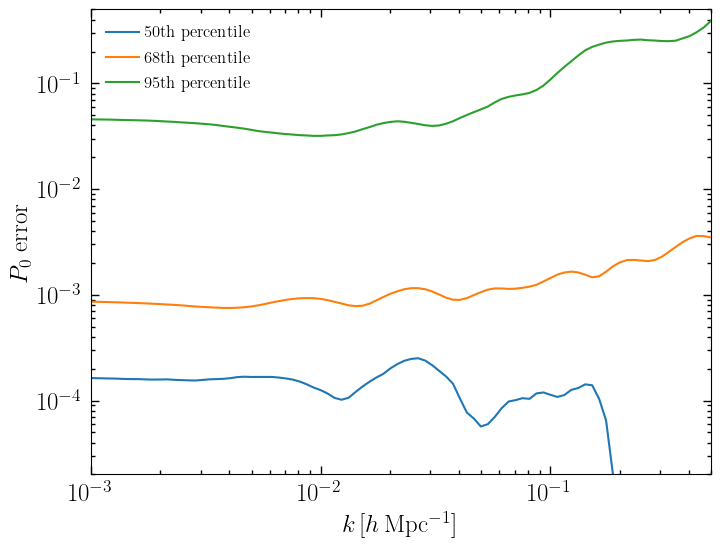

In [31]:
plt.loglog(k, np.percentile(p0err, [50, 68, 95], axis=0).T)
plt.xlabel(r'$k \, [h\, \rm Mpc^{-1}]$')
plt.ylabel(r'$P_0$ error')
plt.ylim([2e-5, 5e-1])
plt.xlim([1e-3, 0.5])

plt.legend(['50th percentile', '68th percentile', '95th percentile'], fontsize=12)
plt.subplots_adjust(wspace=0.1, hspace=0.0)
